# SIMULATIONS ANALYSIS ACROSS REPLICATIONS 

Enter the number of spatial units (must be a perfect square, e.g., 4, 9, 16, ...): 16
Results for 16 spatial units and 50 Timepoints 

........................................................................
        Estimate  True Param      Bias       MAE    RMSE     R_MAE
Param                                                             
beta_1    3.0136         3.0  0.013613  0.030469  0.0387  0.010156
beta_2    0.0049         0.0  0.004937  0.034146  0.0425       NaN
beta_3    2.0092         2.0  0.009224  0.031771  0.0387  0.015885
phi_1     0.0152         0.0  0.015197  0.015197  0.0223       NaN
phi_2     0.0165         0.0  0.016477  0.016477  0.0246       NaN
phi_3     0.0158         0.0  0.015815  0.015815  0.0234       NaN
phi_4     0.0181         0.0  0.018092  0.018092  0.0270       NaN
phi_5     0.2939         0.3 -0.006139  0.025235  0.0319  0.084115
phi_6     0.2889         0.3 -0.011125  0.031047  0.0374  0.103491
phi_7     0.2972         0.3 -0.002849  0.026445  0.033

4


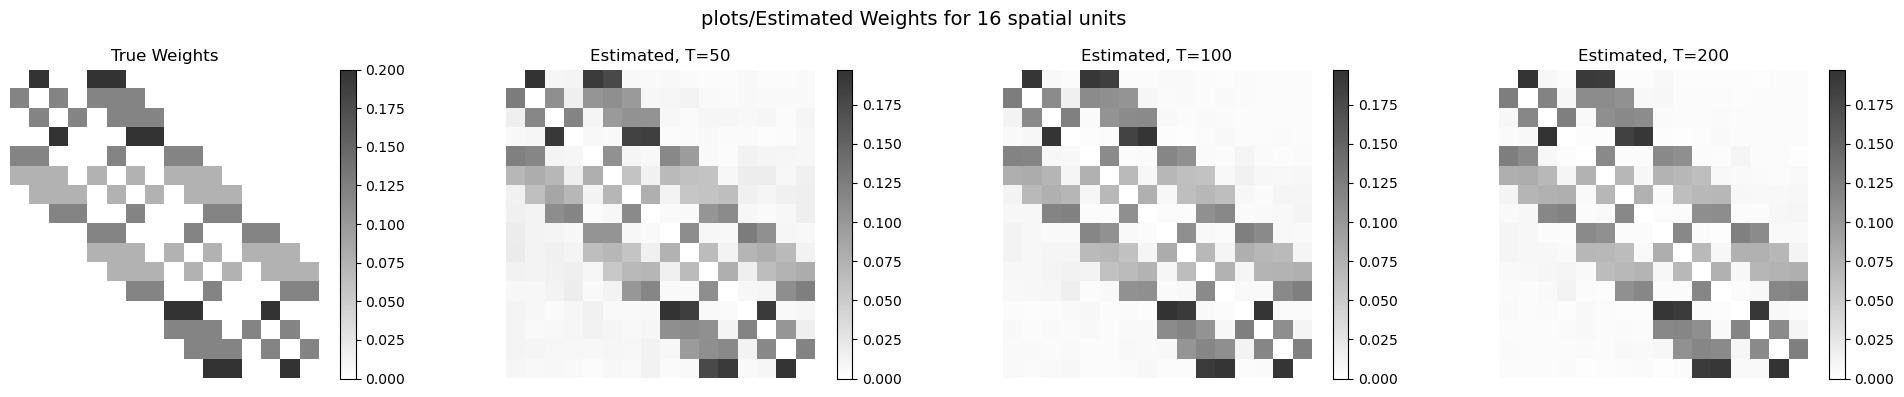

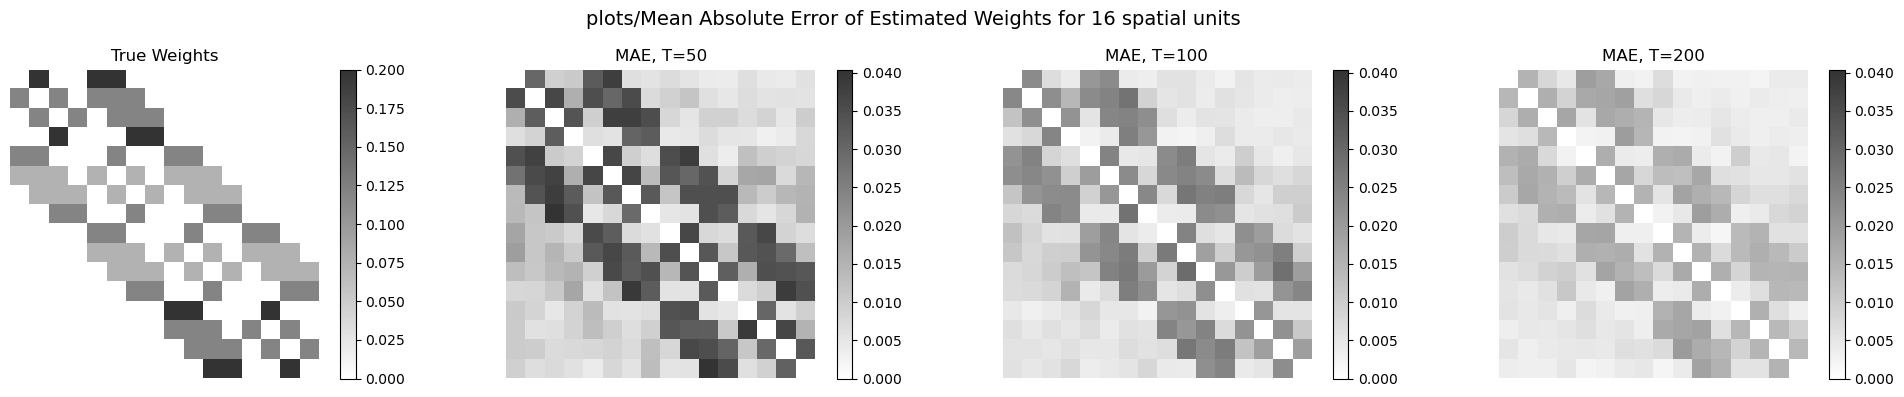

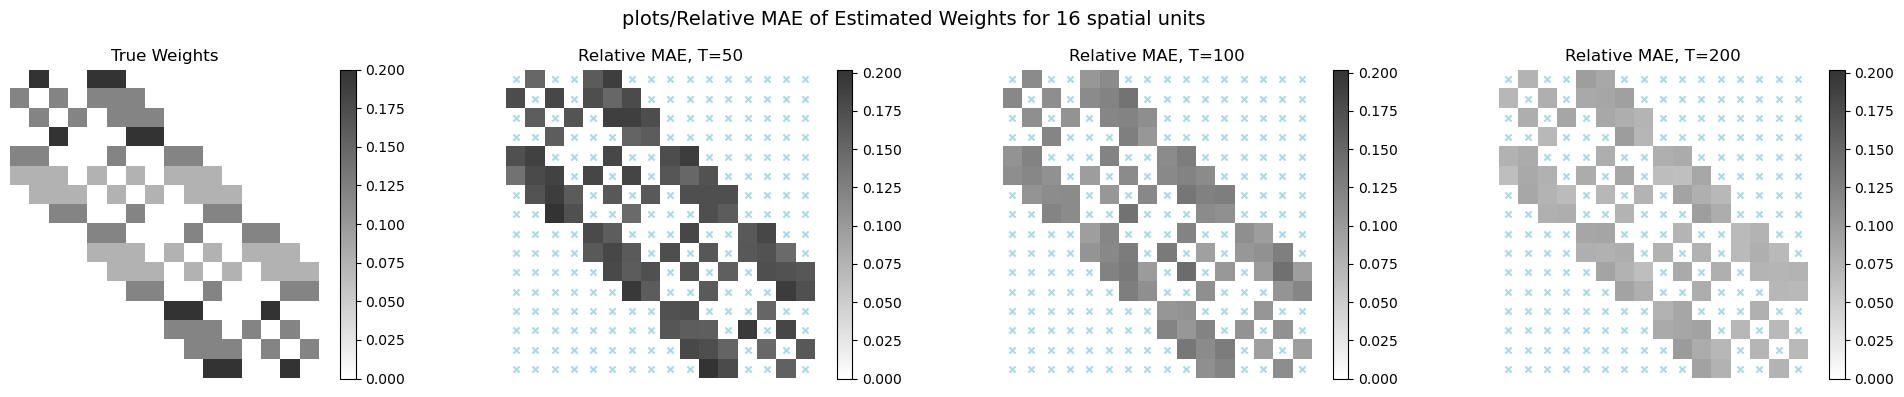

Estimated parameters summary statistics for 16 spatila units


50                                  100          \
                      Bias    RMSE     MAE   R_MAE        Bias    RMSE   
Parameter                                                                
Beta                0.0093  0.0400  0.0321  0.0130      0.0041  0.0273   
Phi                 0.0014  0.0324  0.0251  0.0935      0.0008  0.0224   
W(Full)             0.0025  0.0267  0.0177  0.3330      0.0018  0.0182   
W(zero)             0.0088  0.0183  0.0088     NaN      0.0062  0.0125   
W(non zero)        -0.0093  0.0423  0.0341  0.3330     -0.0064  0.0287   
Sigma              -0.1762  0.1823  0.1762  0.1762     -0.0847  0.0928   
Average time     9544.0874     NaN     NaN     NaN  14079.6616     NaN   
Estimation_RMSE     1.5531     NaN     NaN     NaN      1.4692     NaN   

                                        200                          
                    MAE   R_MAE        Bias    RMSE     MAE   R_MAE  
Parameter                                                            
Beta             0.0217  0.0088      0.0037  0.0183  0.0146  0.0063  
Phi              0.0176  0.0628      0.0029  0.0165  0.0129  0.0428  
W(Full)          0.0121  0.2246      0.0014  0.0135  0.0088  0.1530  
W(zero)          0.0062     NaN      0.0050  0.0101  0.0050     NaN  
W(non zero)      0.0230  0.2246     -0.0054  0.0197  0.0158  0.1530  
Sigma            0.0847  0.0847     -0.0375  0.0448  0.0392  0.0392  
Average time        NaN     NaN  23599.5181     NaN     NaN     NaN  
Estimation_RMSE     NaN     NaN      1.4448     NaN     NaN     NaN

In [71]:
##########################################################################################################################
import os
import csv
import time
import numpy as np
import pandas as pd
import math
import scipy.sparse as sp #Provides functions and classes to work efficiently with sparse matrices
from libpysal.weights import lat2W #creates spatial weights for a regular lattice/grid
from scipy.linalg import solve
from scipy.optimize import minimize
import matplotlib.pyplot as plt 
import itertools
import concurrent.futures
import matplotlib.colors as mcolors
from memory_profiler import profile
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor
#########################################################################################################################
#########################################################################################################################
# Set working directory
#os.chdir('~\\STAR_LASSO')
##########################################################################################################################
# -----------Parameter initialization ------------------------------------------- 
while True:
    n = int(input("Enter the number of spatial units (must be a perfect square, e.g., 4, 9, 16, ...): "))
    if n > 0 and math.isqrt(n)**2 == n:
        break  # valid perfect square
    print("Invalid input! Please enter a perfect square number so a square grid can be created.")
    
#------------create the weights matrix-Queens contiguity---------------------------
WM = np.array(lat2W(int(np.sqrt(n)), int(np.sqrt(n)), rook=False).full()[0],dtype=float)  # Create Queen contiguity weights and convert to a numpy matrix
np.fill_diagonal(WM, 0)
WM = WM / WM.sum(axis=1, keepdims=True) # Row-normalize
# np.save(f"WM{n}.npy", WM) # Save the weights
#---------------Load the weight matrix and plot --------------------------------------------
#WM = np.load(f"WM{n}.npy") # Load the weights
# cmap_gray = mcolors.LinearSegmentedColormap.from_list("custom_gray", [(1,1,1),(0.2,0.2,0.2)])
# plt.imshow(WM, cmap=cmap_gray, interpolation='none')
# plt.title(f"Spatial Weights matrix, n={n}")
# plt.colorbar(label="Weight")
# plt.axis('off')  # hide axes
# plt.show()
#---------initialize other parameters------------------------------------------------
num_replications = 1
beta = np.array([3, 0, 2])
k = len(beta)
phi = np.array([0] * int(n * 0.25) + [0.3] * (n - int(n * 0.25))) #Temporal coefficient
rho = 0.6   #spatial autoregressive coefficient
A = np.linalg.inv(np.eye(n) - rho * WM) #Find the inverse of (I-W)
parameters = np.concatenate((beta, phi, rho * WM[np.triu_indices(WM.shape[0], k=1)], rho * WM[np.tril_indices(WM.shape[0], k=-1)],[1], [np.nan,np.nan,np.nan,np.nan,np.nan]))
#================================================================================
simul_results_50 = np.load(f'RESULTS/Estimated_results_N={n}_50_timepoints.npy')
simul_results_100 = np.load(f'RESULTS/Estimated_results_N={n}_100_timepoints.npy')
simul_results_200 = np.load(f'RESULTS/Estimated_results_N={n}_200_timepoints.npy')

# Stack the results along a new axis (assuming they have the same shape)
Simul_results = np.array([simul_results_50, simul_results_100, simul_results_200])

# Reshape the array if necessary
Simul_results = Simul_results.reshape(len(Simul_results), Simul_results.shape[1], Simul_results.shape[2])
####################################################################
# Define the timepoints
times = [50, 100, 200]

def print_and_return_parameter_summary(simulations,num_replications):
    import matplotlib.colors as mcolors

    
    est_parameters = [] # Create an array to store estimated parameters for all time points
    parameter_tables = [] # Create an array to store parameter results
    Estimated_matrices = [rho * WM] # Create a list to store weight matrices for all time points
    MAE_matrices = [rho * WM]
    RMAE_matrices= [rho * WM]

    for i, Time in enumerate(times):
        from tabulate import tabulate
        # Get simulation results for the current time point
        Simul_results = simulations[i,:, :] #simulations[:, i, :] #simulations[:, :, i]
        
        # Convert simulation results to a DataFrame
        results_df = pd.DataFrame(Simul_results)
        
        colnames = (["beta_" + str(i) for i in range(1, k+1)] +
                    ["phi_" + str(i) for i in range(1, n+1)] +
                    ["W_" + str(i) for i in range(1, int(n*(n-1))+1)] +
                    ["sigma"] + ["RMSE"] + ["time"] + ["Lambda1"]  + ["Lambda2"] + ["Lambda3"])
        results_df.columns = colnames
        results_df["Replication"] = np.arange(1, num_replications+1)
        results_df = results_df.reindex(columns=["Replication"] + colnames)
        
        ##################################################################
        ####################################################################

        # Long format data
        data = pd.melt(results_df, id_vars=["Replication"], var_name="Param", value_name="Estimate")
        data['true_param'] = np.repeat(parameters, data['Replication'].nunique())  # Add true parameter values to the data
        data['Bias'] = data['Estimate'] - data['true_param']  # Calculate the bias for each parameter
        data['Squared Error'] = (data['Estimate'] - data['true_param']) ** 2

        results_summary = pd.DataFrame({
            'Estimate': data.groupby('Param')['Estimate'].mean().round(4),
            'True Param': data.groupby('Param')['true_param'].first(),
            'Bias': data.groupby('Param')['Bias'].mean(),
            'MAE': data.groupby('Param')['Bias'].apply(lambda x: x.abs().mean()),
            'RMSE': np.sqrt(data.groupby('Param')['Squared Error'].mean()).round(4)})
        # Avoid division by zero by setting Relative MAE for zero parameters to NaN
        results_summary['R_MAE'] = results_summary.apply(
            lambda row: row['MAE'] / row['True Param'] if row['True Param'] != 0 else np.nan, axis=1)

        #Display the average value of parameters across replications together with their rmse and bias
        results_summary = results_summary.reindex(colnames)

        # Append estimated parameters for this time point to the list
        est_parameters.append(results_summary['Estimate'].values)
        #print(f"The estimated parameters for {Time} points are {est_parameters}")

        #--------------Calculate weights matrix W-------------------------
        W_estimated = results_summary.loc[results_summary.index.str.startswith("W"), "Estimate"].values
        W = np.zeros((n, n))
        W[np.triu_indices(n, k=1)] = W_estimated[:int(0.5 * n * (n - 1))]
        W[np.tril_indices(n, k=-1)] = W_estimated[int(0.5 * n * (n - 1)):]
        Estimated_matrices.append(W) # Append the weight matrix to the list
        
        #----------Construct the MAE weights--------------------------------
        W_mae = results_summary.loc[results_summary.index.str.startswith("W"),"MAE"].values  # Extract MAE of W parameters
        MAE_W = np.zeros((n, n))
        MAE_W[np.triu_indices(n, k=1)] = W_mae[:int(0.5*n*(n-1))]
        MAE_W[np.tril_indices(n, k=-1)] = W_mae[int(0.5*n*(n-1)):]
        MAE_matrices.append(MAE_W)
        
        #---- Construct weight matrix of RMAE with masked zeros ------
        mask = (rho * WM) != 0
        MAE_W_rel = np.zeros_like(MAE_W)
        MAE_W_rel[mask] = MAE_W[mask] / np.max(np.abs((rho * WM)[mask]))
        RMAE_matrices.append(MAE_W_rel)
        # Print the results for this time point with bold and big text
        print(f"Results for {n} spatial units and {Time} Timepoints \n")
        print("........................................................................")
        #print("The average parameter values across replications together with bias and RMSE")
        print(results_summary.head(25))
        print("........................................................................")
        
        # Calculate averages
        Est_Beta = results_summary.loc[results_summary.index.str.startswith("beta"), ["Bias",  "RMSE", "MAE","R_MAE" ]].mean().round(4)
        Est_Phi = results_summary.loc[results_summary.index.str.startswith("phi"), ["Bias",  "RMSE", "MAE","R_MAE"]].mean().round(4)
        Est_W_Full = results_summary.loc[results_summary.index.str.startswith("W"), ["Bias", "RMSE", "MAE","R_MAE"]].mean().round(4)
        zero_weights = results_summary.loc[results_summary.index.str.startswith("W")].loc[results_summary['True Param'] == 0]
        non_zero_weights = results_summary.loc[results_summary.index.str.startswith("W")].loc[results_summary['True Param'] != 0]
        Est_W_Zero = zero_weights[["Bias", "RMSE", "MAE","R_MAE"]].mean().round(4)
        Est_W_NonZero = non_zero_weights[["Bias", "RMSE", "MAE","R_MAE"]].mean().round(4)
        Est_Sigma = results_summary.loc[results_summary.index.str.startswith("sigma"), ["Bias", "RMSE", "MAE","R_MAE"]].mean().round(4)
        Average_time = results_summary.loc[results_summary.index.str.startswith("time"), "Estimate"].mean()
        Average_RMSE = results_summary.loc[results_summary.index.str.startswith("RMSE"), "Estimate"].mean()
        
        #----------------------- Parameter results table
        Parameter_results = pd.DataFrame({
        'Parameter': ['Beta', 'Phi', 'W(Full)', 'W(zero)', 'W(non zero)', 'Sigma', 'Average time', 'Estimation_RMSE'],
        'Bias': [Est_Beta['Bias'], Est_Phi['Bias'], Est_W_Full['Bias'], Est_W_Zero['Bias'], Est_W_NonZero['Bias'], Est_Sigma['Bias'], Average_time, Average_RMSE],
        'RMSE': [Est_Beta['RMSE'], Est_Phi['RMSE'], Est_W_Full['RMSE'], Est_W_Zero['RMSE'], Est_W_NonZero['RMSE'], Est_Sigma['RMSE'], np.nan, np.nan],
        'MAE' : [Est_Beta['MAE'], Est_Phi['MAE'], Est_W_Full['MAE'], Est_W_Zero['MAE'], Est_W_NonZero['MAE'], Est_Sigma['MAE'], np.nan, np.nan],
        'R_MAE' : [Est_Beta['R_MAE'], Est_Phi['R_MAE'], Est_W_Full['R_MAE'], Est_W_Zero['R_MAE'], Est_W_NonZero['R_MAE'], Est_Sigma['R_MAE'], np.nan, np.nan]
        })
        parameter_tables.append(Parameter_results)
        # Print the percentages
        print(f"\n The parameter summary statistics for {n} Spatial units and {Time} timepoints")
        print(tabulate(Parameter_results, headers='keys', tablefmt='pretty', showindex=False))
    ###################################################################
    # Combine side by side
    # After the loop, combine parameter tables side by side
    parameter_tables = [df.set_index('Parameter') for df in parameter_tables]
    
    # Concatenate along columns, using keys=times to create MultiIndex columns
    combined_parameters = pd.concat(parameter_tables, axis=1, keys=times)
    combined_parameters.to_pickle(f"RESULTS/Combined_Parameter_results_N={n}.pkl")  # Save
    print(len(MAE_matrices))
    print("============================================================================================================================")
    print("============================================================================================================================")
    #############################################################################################################
    #############################################################################################################
    def plot_three_weight_figures(Estimated_matrices, MAE_matrices, RMAE_matrices, times, n):
        # Create custom grayscale colormap
        colors = [(1, 1, 1), (0.2, 0.2, 0.2)]
        cmap_gray = mcolors.LinearSegmentedColormap.from_list('custom_gray', colors)

        # Helper function to plot a single figure
        def plot_matrix_figure(matrix_list, figure_title, subplot_titles, mask=None):
            fig, axs = plt.subplots(1, len(matrix_list), figsize=(20, 4))
            vmin_true, vmax_true = np.min(matrix_list[0]), np.max(matrix_list[0])
            vmin_others = min(np.min(img) for img in matrix_list[1:])
            vmax_others = max(np.max(img) for img in matrix_list[1:])

            for j, (ax, img, title) in enumerate(zip(axs, matrix_list, subplot_titles)):
                if j == 0:
                    im = ax.imshow(img, cmap=cmap_gray, origin='upper', vmin=vmin_true, vmax=vmax_true)
                else:
                    im = ax.imshow(img, cmap=cmap_gray, origin='upper', vmin=vmin_others, vmax=vmax_others)

                # Only add markers if mask is provided (for Relative MAE)
                if mask is not None and j != 0:  # do not mark the first column (true weights)
                    ys, xs = np.where(~mask)
                    ax.scatter(xs, ys, marker='x', color='lightblue', s=20)
                    #ax.legend(loc='upper right', fontsize=8)

                ax.set_title(title)
                ax.axis("off")
                plt.colorbar(im, ax=ax, fraction=0.046)

            plt.suptitle(figure_title, fontsize=14)
            plt.tight_layout()
            plt.show()

        # --------- Plot 1: True + Estimated Weights ---------
        subplot_titles = ["True Weights"] + [f"Estimated, T={t}" for t in times]
        plot_matrix_figure(Estimated_matrices, f"plots/Estimated Weights for {n} spatial units", subplot_titles)

        # --------- Plot 2: True + MAE Weights ---------
        subplot_titles = ["True Weights"] + [f"MAE, T={t}" for t in times]
        plot_matrix_figure(MAE_matrices, f"plots/Mean Absolute Error of Estimated Weights for {n} spatial units", subplot_titles)

        # --------- Plot 3: True + Relative MAE Weights ---------
        mask = (Estimated_matrices[0] != 0)  # Only mark positions where true weight is zero
        subplot_titles = ["True Weights"] + [f"Relative MAE, T={t}" for t in times]
        plot_matrix_figure(RMAE_matrices, f"plots/Relative MAE of Estimated Weights for {n} spatial units", subplot_titles, mask=mask)

    # Call the function
    plot_three_weight_figures(Estimated_matrices, MAE_matrices, RMAE_matrices, times, n)
    ######################################################################################################################
print_and_return_parameter_summary(Simul_results,Simul_results.shape[1])
print("=========================================================================================")
print("=========================================================================================")
print(f"Estimated parameters summary statistics for {n} spatila units")
Combined_parameters = pd.read_pickle(f"RESULTS/Combined_Parameter_results_N={n}.pkl")
Combined_parameters
